In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

from torchvision import models
from torchvision import transforms

from captum.attr import visualization as viz
from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution

In [2]:
# Default device plus free memory
torch.cuda.empty_cache()
device = "cpu"

In [3]:
# Model
#fcn_model = models.segmentation.fcn_resnet50(pretrained=True).to(device).eval()
fcn_model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True).to(device).eval()
# Input preprocessing transformation
preprocessing = transforms.Compose([transforms.Resize(640), 
                                    transforms.ToTensor()])
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# This method allows us to visualize a particular segmentation output, by setting
# each pixels color according to the given segmentation class provided in the 
# image (segmentation output).
def decode_segmap(image, nc=21):  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [5]:
# Get a image from the dataset
!wget -nv --directory-prefix=img/segmentation/ https://farm8.staticflickr.com/7301/8862358875_eecba9fb10_z.jpg

2023-09-08 10:38:45 URL:https://farm8.staticflickr.com/7301/8862358875_eecba9fb10_z.jpg [110427] -> "img/segmentation/8862358875_eecba9fb10_z.jpg.13" [1]


/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/fonta42/anaconda3/envs/torchtrainer/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/fonta42/anaconda3/envs/torchtrainer/li

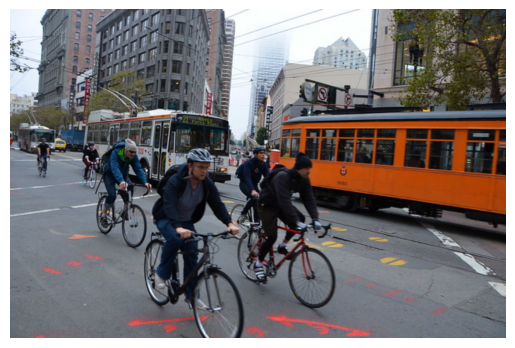

In [6]:
# %matplotlib inline
img = Image.open("img/segmentation/8862358875_eecba9fb10_z.jpg")
preproc_img = preprocessing(img)
_ = plt.imshow(preproc_img.permute(1,2,0)); plt.axis('off')
_ = plt.show()

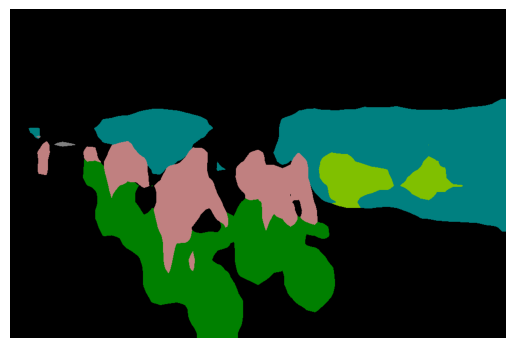

In [7]:
# Normalize image and compute segmentation output
normalized_inp = normalize(preproc_img).unsqueeze(0).to(device)
normalized_inp.requires_grad = True
out = fcn_model(normalized_inp)['out']

# Find most likely segmentation class for each pixel.
out_max = torch.argmax(out, dim=1, keepdim=True)

# Visualize segmentation output using utility method.
rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
_ = plt.imshow(rgb); plt.axis('off'); plt.show()

In [8]:
def wrapper_pix(inp):
    model_out = fcn_model(inp)['out']
    return (model_out[0:1, :, 263, 705])

In [9]:
#fcn_model

In [10]:
# Gradcam for layers
#layer_gradcam = LayerGradCam(wrapper_pix, fcn_model.backbone.layer4[0].conv3)
layer_gradcam = LayerGradCam(wrapper_pix, fcn_model.backbone['1'].block[0][0])

gradcam_attr = layer_gradcam.attribute(normalized_inp, 
                                  target=19, 
                                  attr_dim_summation=False).detach().cpu()
gradcam_attr.shape

torch.Size([1, 16, 320, 483])

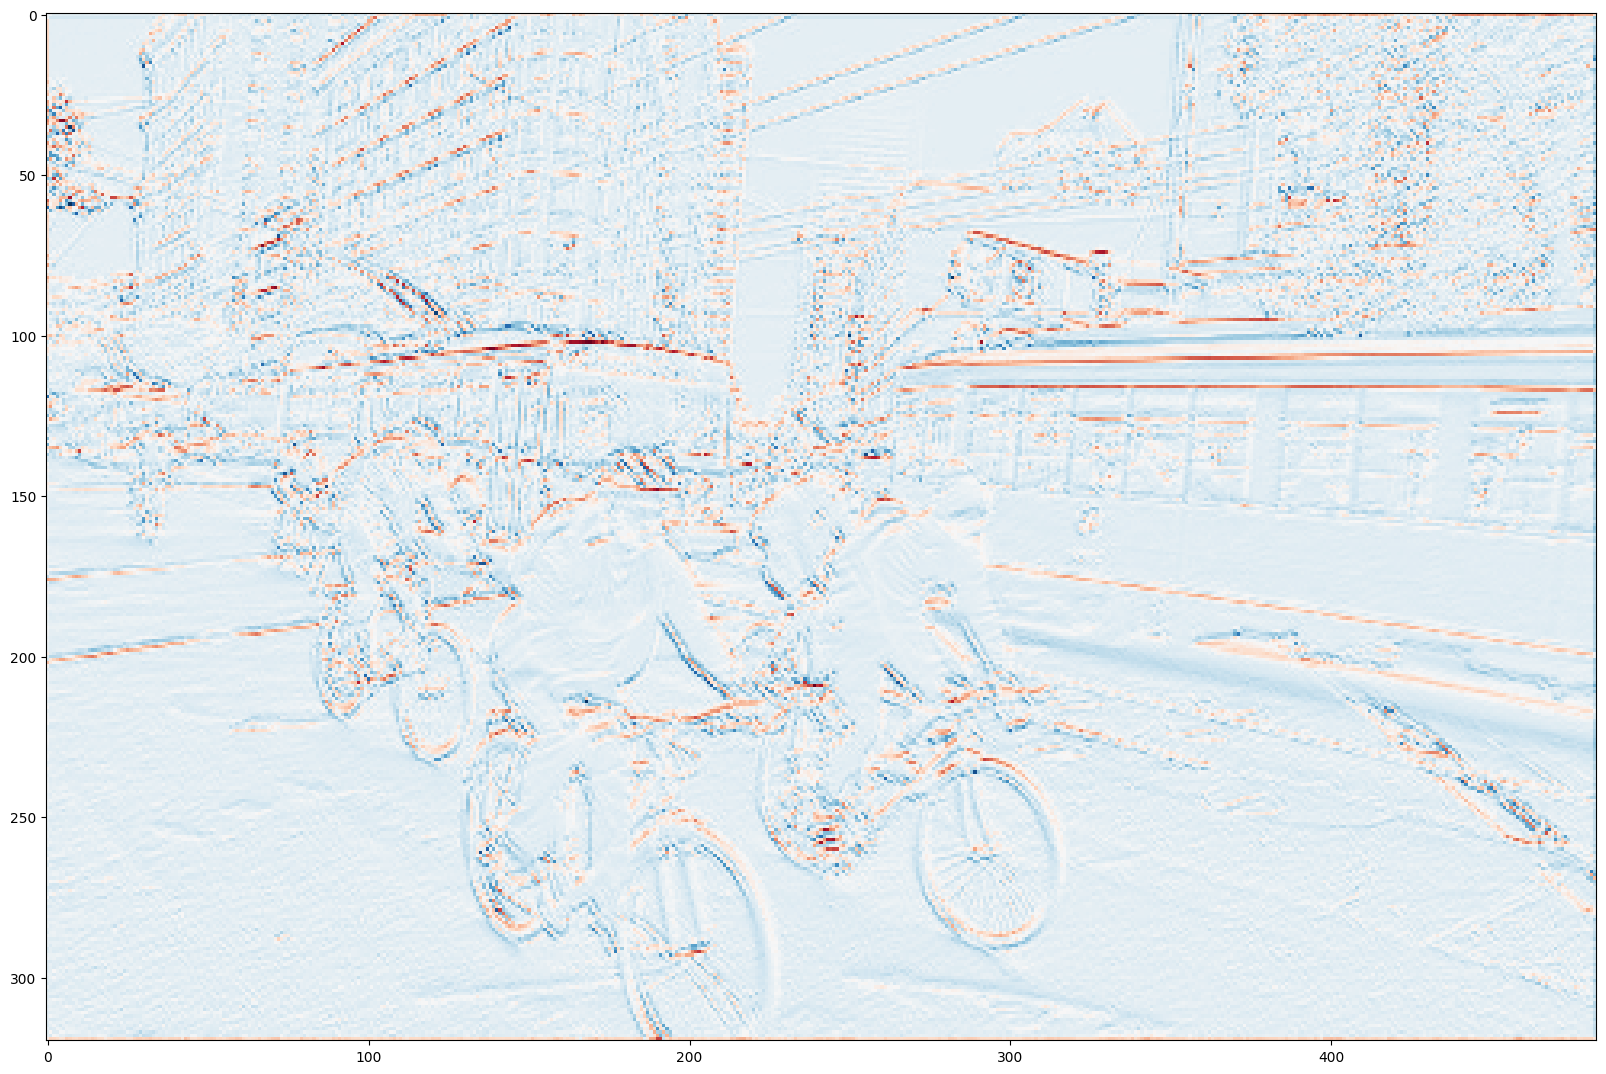

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# Sum of channels = same as attr_dim_summation=True
sum_maps = gradcam_attr.sum(dim=1)

_ = plt.figure(figsize=[20,20])
_ = plt.imshow(sum_maps[0].numpy(), 
                 cmap='RdBu')

In [12]:
outputs = []
def black_out_region_hook(module, input, output, x1, y1, x2, y2):
    outputs.append(output.detach().cpu().numpy())
    output_clone = output.clone()
    output_clone[:, :, y1:y2, x1:x2] = 0
    outputs.append(output_clone.detach().cpu().numpy())
    return output_clone

In [13]:
x1, y1, x2, y2 = 0, 0, 120, 20  # example coordinates

hook_handle = fcn_model.backbone['1'].block[0][0].register_forward_hook(lambda mod, inp, out: black_out_region_hook(mod, inp, out, x1, y1, x2, y2))

#hook_handle.remove()

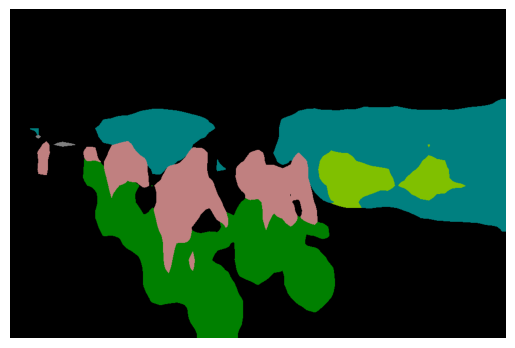

In [14]:
out = fcn_model(normalized_inp)['out']

# Find most likely segmentation class for each pixel.
out_max = torch.argmax(out, dim=1, keepdim=True)

# Visualize segmentation output using utility method.
rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
_ = plt.imshow(rgb); plt.axis('off'); plt.show()

(1, 16, 320, 483)


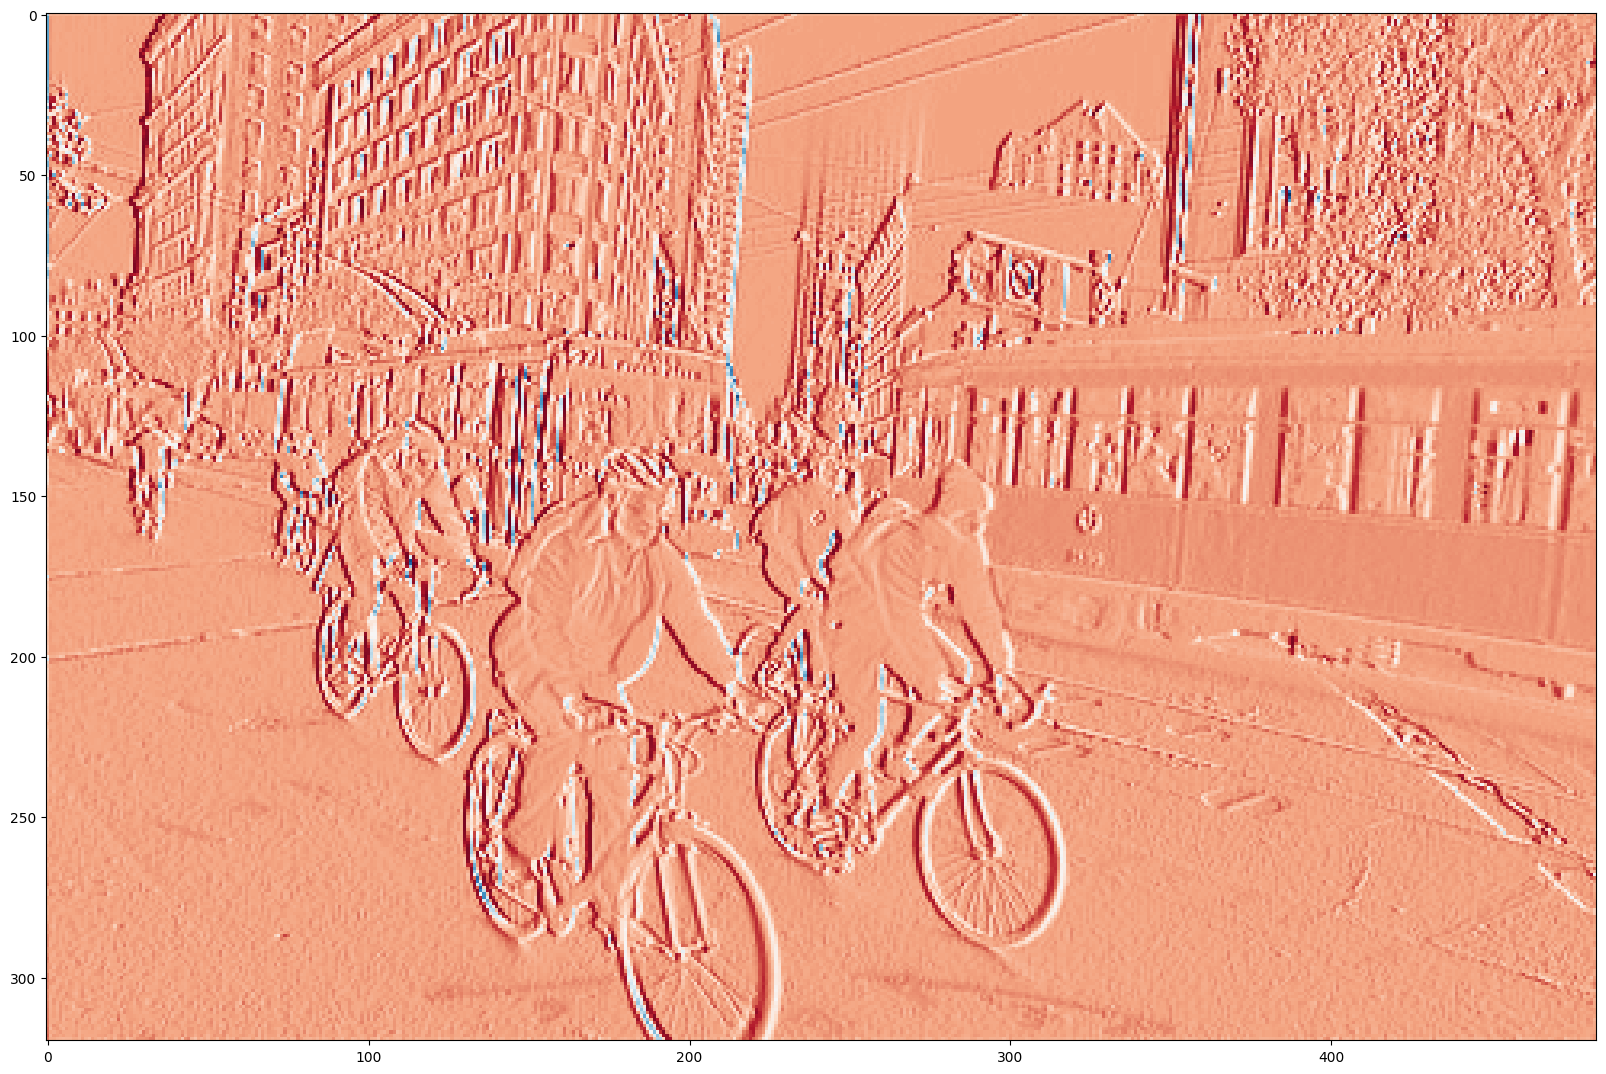

In [15]:
print(outputs[0].shape)
_ = plt.figure(figsize=[20,20])
_ = plt.imshow(np.squeeze(outputs[0][:, 0, :, :]), 
                 cmap='RdBu')

(1, 16, 320, 483)


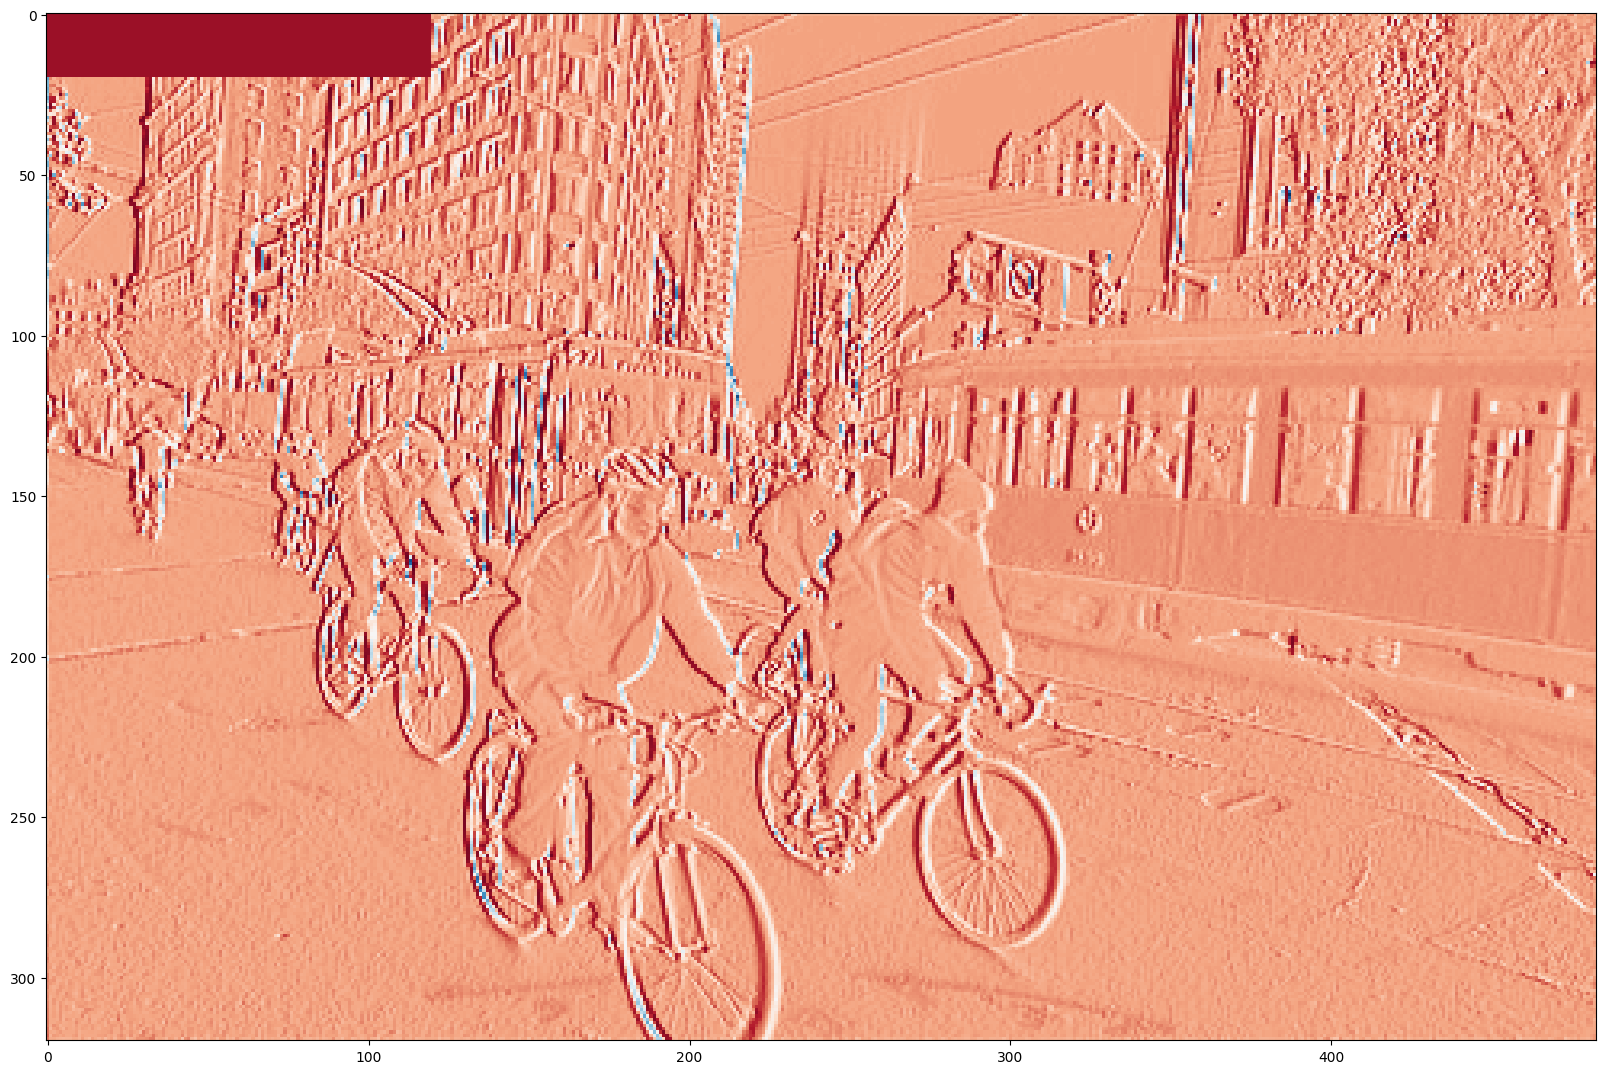

In [16]:
print(outputs[1].shape)
_ = plt.figure(figsize=[20,20])
_ = plt.imshow(np.squeeze(outputs[1][:, 0, :, :]), 
                 cmap='RdBu')

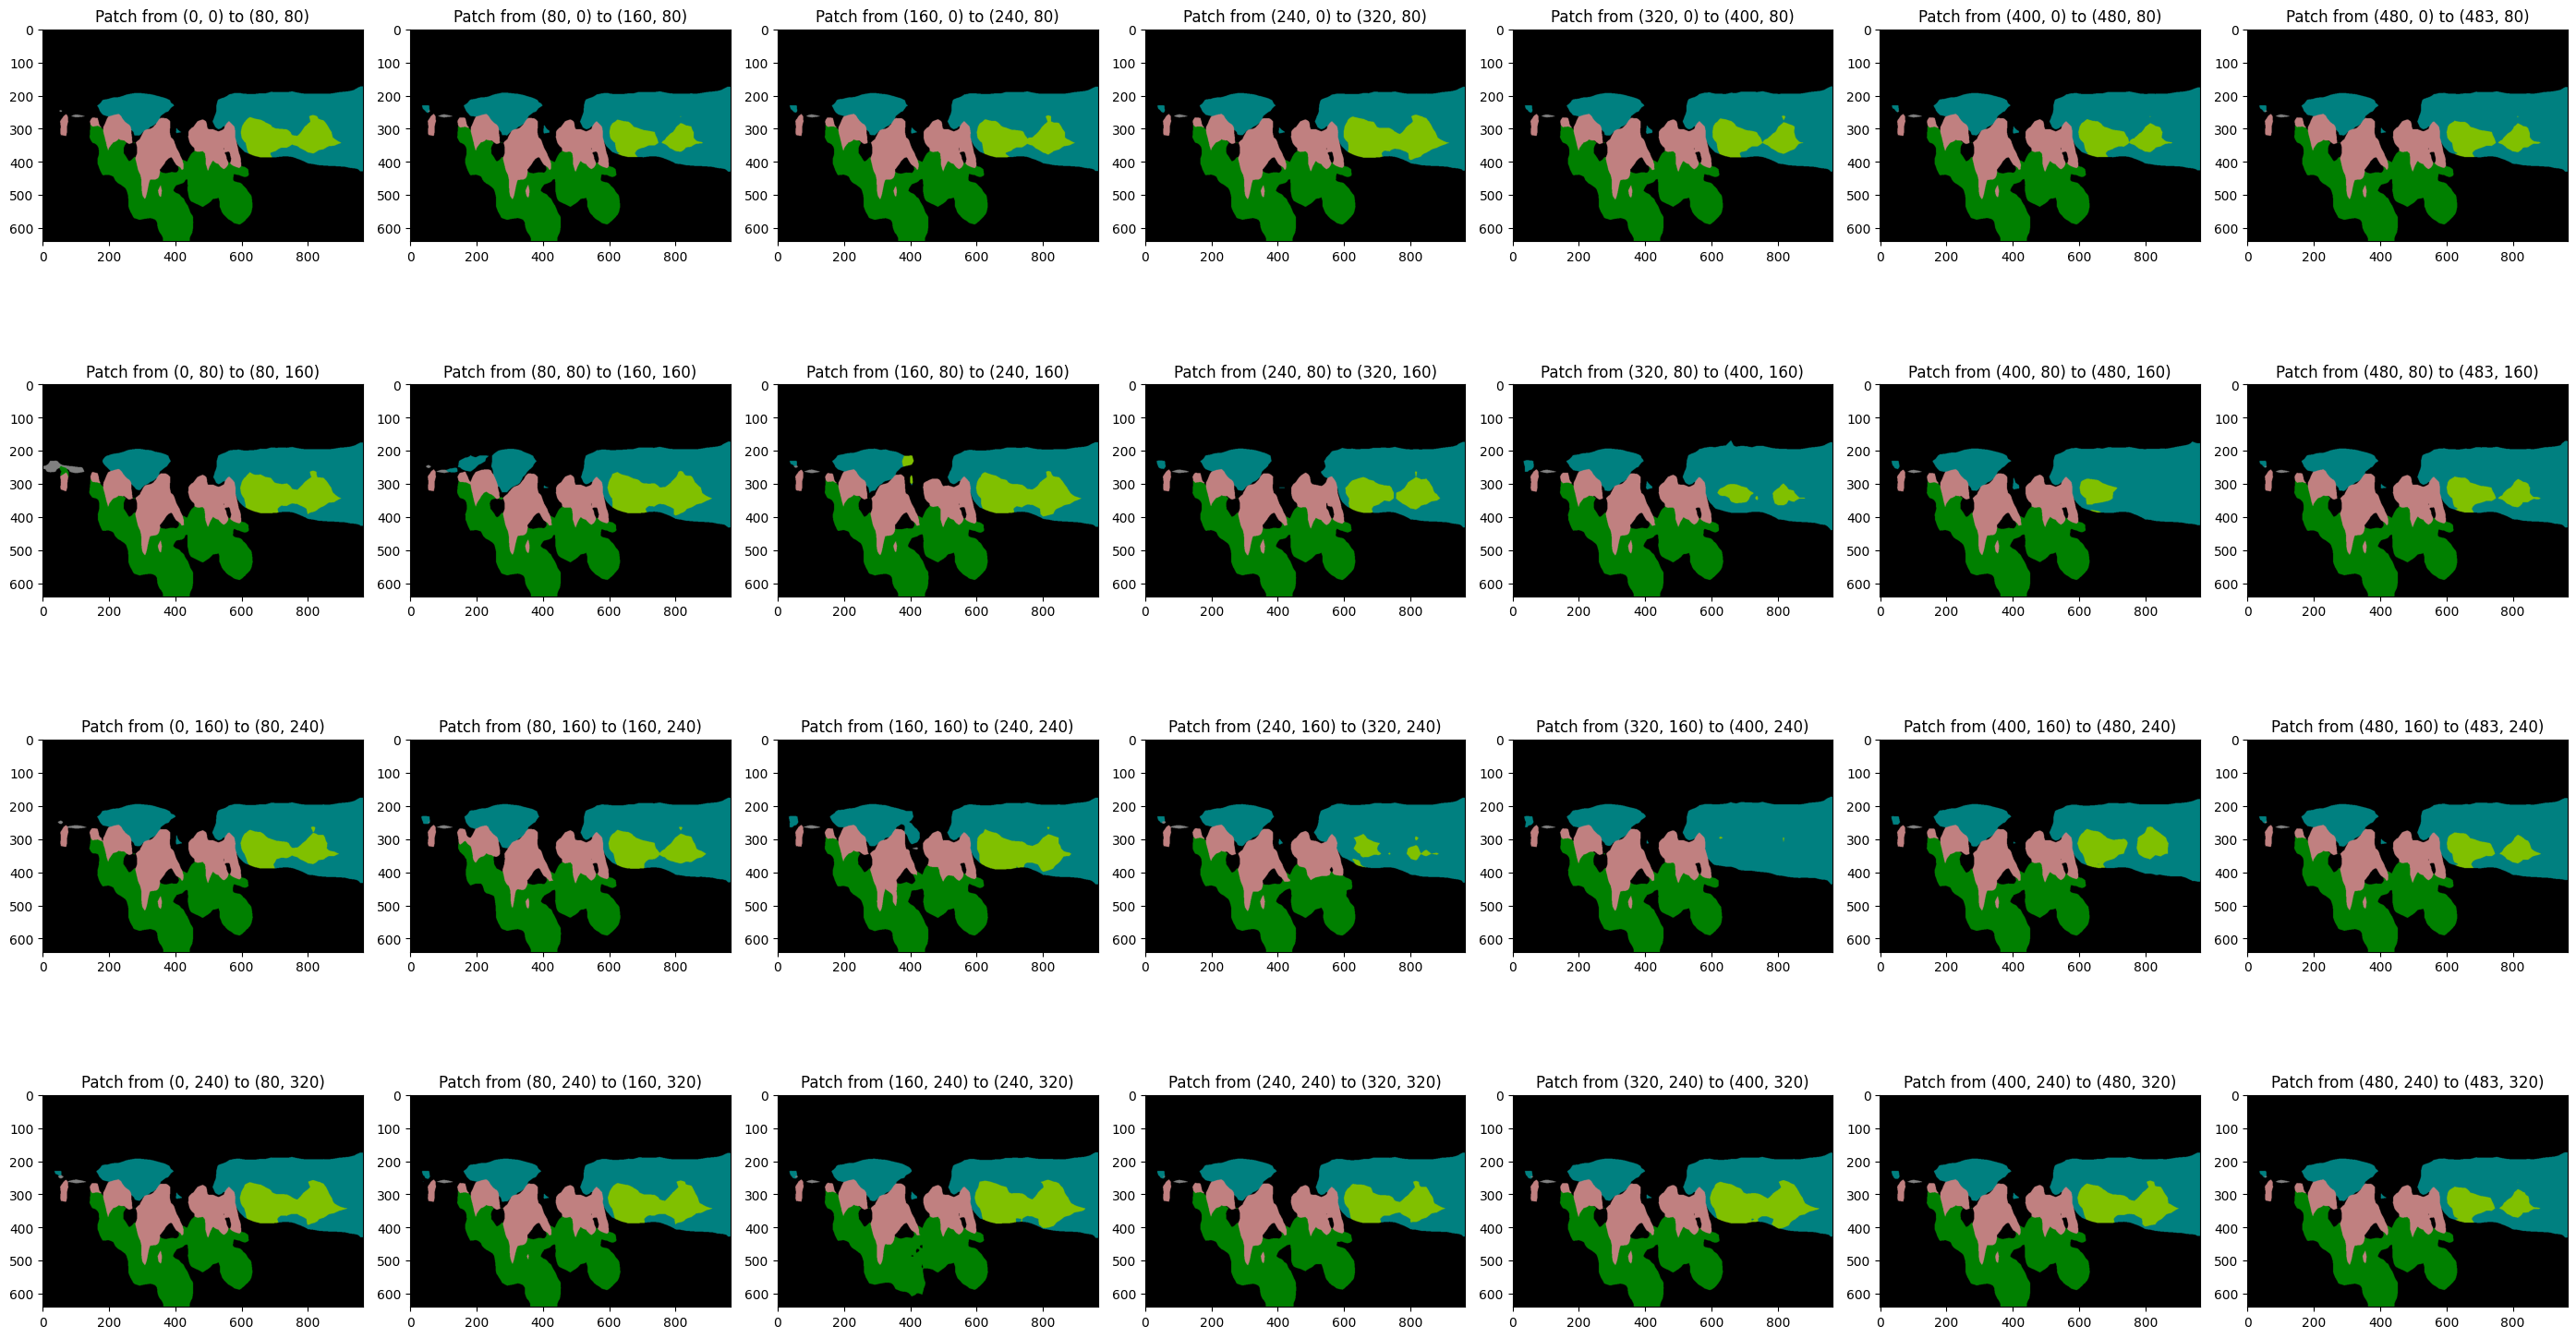

In [18]:
patch_size = 80  # 40x40 patches

# Layer dimensions
height, width = 320, 483

# Calculate number of subplots
rows = (height + patch_size - 1) // patch_size
cols = (width + patch_size - 1) // patch_size

# Create a large figure to hold all subplots
plt.figure(figsize=(cols * 4, rows * 4))  #  subplot 4x4 inches

plot_idx = 1  # Index for subplot

for i in range(0, height, patch_size):
    for j in range(0, width, patch_size):
        x1, y1 = j, i
        x2, y2 = min(j + patch_size, width), min(i + patch_size, height)
        
        # Register hook for every iteration
        #hook_handle = fcn_model.backbone.layer4[2].conv3.register_forward_hook(lambda mod, inp, out: black_out_region_hook(mod, inp, out, x1, y1, x2, y2))
        hook_handle = fcn_model.backbone['1'].block[0][0].register_forward_hook(lambda mod, inp, out: black_out_region_hook(mod, inp, out, x1, y1, x2, y2))


        # Trigger the hook and model evaluation
        with torch.no_grad():
            out = fcn_model(normalized_inp)['out']
        
        hook_handle.remove()  # Remove hook after using
        
        # Decoding of result
        out_max = torch.argmax(out, dim=1, keepdim=True)
        rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
        
        plt.subplot(rows, cols, plot_idx)
        plt.imshow(rgb)
        plt.title(f'Patch from ({x1}, {y1}) to ({x2}, {y2})')
        
        plot_idx += 1

# Finally, display the entire figure
plt.tight_layout()
plt.show()